In [1]:
import pathlib, csv, os, re, collections, numpy as np

def get_output_folder_from_config(project_dir: str) -> str:
    """Read config.txt and extract the Output Folder Path."""
    config_path = os.path.join(project_dir, 'config.txt')
    if not os.path.exists(config_path):
        raise FileNotFoundError(f'config.txt not found: {config_path}')
    
    with open(config_path, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if 'Output Folder Path' in line:
                # The next non-empty, non-comment line should be the path
                if i + 1 < len(lines):
                    path_line = lines[i+1].strip()
                    if path_line and not path_line.startswith('#'):
                        return path_line
    raise ValueError('Output Folder Path not found in config.txt')

def load_tracks(project_dir: str):
    """Load tracks from the ConvergeTrack CSV files.
    First reads config.txt to get Output Folder Path, then looks for ConvergeTrack folder.
    Returns a dict: {track_id: [(frame_id, x, y, z, cam_2d_dict), ...]}
    """
    # Get output folder from config.txt
    output_folder = get_output_folder_from_config(project_dir)
    track_dir = os.path.join(output_folder, 'ConvergeTrack0')
    
    if not os.path.isdir(track_dir):
        # Fallback to default location
        fallback_dir = os.path.join(project_dir, 'Results', 'ConvergeTrack')
        if os.path.isdir(fallback_dir):
            track_dir = fallback_dir
        else:
            raise FileNotFoundError(f'ConvergeTrack directory not found: {track_dir}')
    
    print(f'Loading tracks from: {track_dir}')
    
    # Helper for natural sorting
    def natsort_key(s):
        return [int(t) if t.isdigit() else t.lower() for t in re.split('([0-9]+)', s)]
    
    patterns = ['LongTrackActive', 'LongTrackInactive', 'ExitTrack']
    tracks = collections.defaultdict(list)
    max_id_overall = -1
    
    for pattern in patterns:
        files = sorted([f for f in os.listdir(track_dir) if f.startswith(pattern) and f.endswith('.csv')], key=natsort_key)
        for filename in files:
            file_path = os.path.join(track_dir, filename)
            with open(file_path, 'r', newline='') as f:
                reader = csv.reader(f)
                header = next(reader, None)  # skip header
                local_max_id = -1
                offset = max_id_overall + 1
                for row in reader:
                    if not row:
                        continue
                    try:
                        orig_id = int(row[0])
                        frame_id = int(row[1])
                        x, y, z = map(float, row[2:5])
                        track_id = orig_id + offset
                        # Tracer format: start_col=5, stride=2
                        start_col = 5
                        stride = 2
                        cam_idx = 0
                        cam_2d = {}
                        col = start_col
                        while col + 1 < len(row):
                            cam_x = float(row[col])
                            cam_y = float(row[col + 1])
                            if cam_x > 0 and cam_y > 0:
                                cam_2d[cam_idx] = (cam_x, cam_y, 5.0)
                            col += stride
                            cam_idx += 1
                        tracks[track_id].append((frame_id, x, y, z, cam_2d))
                        if orig_id > local_max_id:
                            local_max_id = orig_id
                    except (ValueError, IndexError):
                        continue
                if local_max_id != -1:
                    max_id_overall += (local_max_id + 1)
    return dict(tracks)

# Example usage
project_root = r'I:/VONSET/Data/20230125/T1/Processed'
tracks = load_tracks(project_root)
print(f'Loaded {len(tracks)} tracks')

# Show first few track IDs and their first entry
for tid, pts in list(tracks.items())[:5]:
    print(tid, pts[0])

Loading tracks from: I:/VONSET/Data/20230125/T1/Processed/Results\ConvergeTrack0
Loaded 10504 tracks
0 (0, -14.236265, -12.810389, 9.885088, {0: (507.836408, 242.189247, 5.0), 1: (542.962395, 301.020336, 5.0), 2: (353.960487, 250.566848, 5.0), 3: (369.641514, 232.558144, 5.0)})
1 (31, -15.335186, -22.744001, 3.104889, {0: (460.384466, 19.175857, 5.0), 1: (669.884313, 33.527034, 5.0), 2: (473.43938, 2.081778, 5.0)})
2 (196, 12.109022, -14.752827, -18.398932, {0: (1049.763254, 128.836865, 5.0), 1: (662.919942, 10.621901, 5.0), 2: (1054.548992, 0.784766, 5.0), 3: (1235.647716, 51.295687, 5.0)})
3 (211, -7.16887, -21.929456, 7.455804, {0: (645.828321, 30.886632, 5.0), 1: (462.69279, 46.30277, 5.0), 2: (392.511171, 0.926669, 5.0)})
4 (219, -18.28278, -21.092824, -12.531233, {0: (373.077365, 39.447975, 5.0), 1: (1011.625656, 0.759495, 5.0), 2: (842.46263, 1.165495, 5.0), 3: (586.326445, 15.328522, 5.0)})


Found 4 cameras
Loading 100 images for overlay using OpenCV...
Drawing tracks...
Indexed 36342 track points for interaction.
Displaying static image (8x width)...


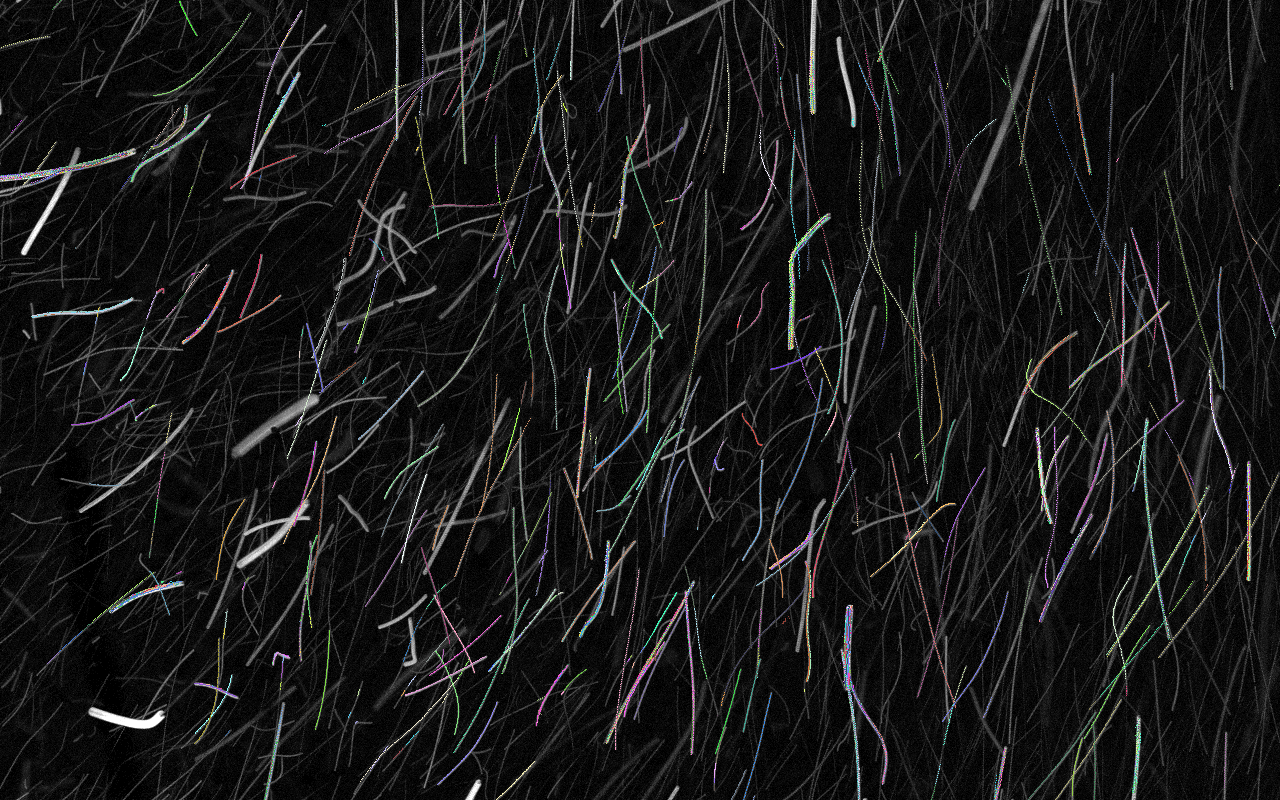

Opening interactive popup... Click near a track to see its ID.


In [15]:
import cv2
import numpy as np
from IPython.display import display, Image
import os
from scipy.spatial import cKDTree

camera_idx = 0  # Change this to view other cameras
frame_start = 1
frame_end = 100
overlay_mode = 'max'  # 'max', 'mean', or 'sum'

def get_image_paths_from_config(project_dir: str) -> dict:
    """Read config.txt to find Image File Path sections.
    Returns: {cam_idx: [list of image paths]}
    """
    config_path = os.path.join(project_dir, 'config.txt')
    if not os.path.exists(config_path):
        raise FileNotFoundError(f'config.txt not found: {config_path}')
    
    image_name_files = []  # List of .txt files containing image paths
    
    with open(config_path, 'r') as f:
        lines = f.readlines()
        is_img_section = False
        for line in lines:
            line_stripped = line.strip()
            if not line_stripped:
                continue
            
            if line_stripped.startswith('# Image File Path'):
                is_img_section = True
                continue
            
            if is_img_section:
                if line_stripped.startswith('#'):  # Next section
                    break
                if not line_stripped.startswith('!'):  # Valid path
                    # Handle potential relative paths
                    if not os.path.isabs(line_stripped):
                        line_stripped = os.path.normpath(os.path.join(project_dir, line_stripped))
                    image_name_files.append(line_stripped)
    
    # Load actual image paths from each txt file
    cam_image_paths = {}
    for cam_i, txt_path in enumerate(image_name_files):
        cam_image_paths[cam_i] = []
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                img_lines = [l.strip() for l in f if l.strip()]
                cam_image_paths[cam_i] = [os.path.normpath(l) for l in img_lines]
    
    return cam_image_paths

# Load image paths
cam_image_paths = get_image_paths_from_config(project_root)
print(f'Found {len(cam_image_paths)} cameras')

# Get images for the specified camera and frame range
if camera_idx not in cam_image_paths:
    raise ValueError(f'Camera {camera_idx} not found')

image_paths = cam_image_paths[camera_idx]
selected_paths = image_paths[frame_start-1:frame_end]
print(f'Loading {len(selected_paths)} images for overlay using OpenCV...')

# Load and overlay images using OpenCV
images = []
for img_path in selected_paths:
    if os.path.exists(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
        else:
            print(f'Warning: Failed to load image: {img_path}')
    else:
        print(f'Warning: Image not found: {img_path}')

if not images:
    raise ValueError('No images loaded!')

# Stack and Project
stack = np.stack(images, axis=0).astype(np.float32)

if overlay_mode == 'max':
    overlay = np.max(stack, axis=0)
elif overlay_mode == 'mean':
    overlay = np.mean(stack, axis=0)
elif overlay_mode == 'sum':
    overlay = np.sum(stack, axis=0)
else:
    overlay = np.max(stack, axis=0)

# Normalize for display (0-255)
overlay_norm = cv2.normalize(overlay, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
display_img = cv2.cvtColor(overlay_norm, cv2.COLOR_GRAY2BGR)

# Data structures for interactivity
all_points = [] # list of [x, y]
point_to_id = {} # map index in all_points to track_id

# Draw Tracks
print('Drawing tracks...')
for tid, pts in tracks.items():
    np.random.seed(tid)
    color_bgr = tuple(int(x) for x in np.random.randint(50, 255, 3))
    
    for frame_id, x, y, z, cam_2d in pts:
        if frame_start <= frame_id <= frame_end:
            if camera_idx in cam_2d:
                px, py, _ = cam_2d[camera_idx]
                ix, iy = int(px), int(py)
                
                # Draw 2x2 pixels
                y_max = min(iy + 1, display_img.shape[0])
                x_max = min(ix + 1, display_img.shape[1])
                if iy < y_max and ix < x_max:
                    display_img[iy:y_max, ix:x_max] = color_bgr
                    
                    # Store for query (store center-ish)
                    all_points.append([px, py])
                    point_to_id[len(all_points)-1] = tid

# Build search tree
if all_points:
    tree = cKDTree(all_points)
    print(f'Indexed {len(all_points)} track points for interaction.')
else:
    tree = None
    print('No track points found in this view.')

# Display inline (Static)
print('Displaying static image (8x width)...')
_, encoded_img = cv2.imencode('.png', display_img)
display(Image(data=encoded_img, width=display_img.shape[1] * 8))

# Interactive Popup with Mouse Callback
print("Opening interactive popup... Click near a track to see its ID.")
win_name = "Track Visualization"

def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        clean_img, tree, point_to_id, all_points = param
        if tree is None: return
        
        # Query nearest point
        dist, idx = tree.query([x, y], k=1)
        
        # Always start from the clean image (clears previous IDs)
        img_to_show = clean_img.copy()
        
        if dist < 10: # Clicked within 10 pixels
            # Found a track
            track_id = point_to_id[idx]
            target_x, target_y = all_points[idx]
            
            text = f"ID: {track_id}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            thickness = 1
            text_color = (255, 255, 255)
            bg_color = (0, 0, 0)
            
            # Get text size for background box
            (text_w, text_h), baseline = cv2.getTextSize(text, font, font_scale, thickness)
            
            # Position
            pt_int = (int(target_x), int(target_y))
            text_x = pt_int[0] + 5
            text_y = pt_int[1] - 5
            
            # Draw semi-transparent background box
            cv2.rectangle(img_to_show, (text_x - 2, text_y - text_h - 2), (text_x + text_w + 2, text_y + baseline + 2), bg_color, -1)
            
            # Draw indicator circle and text
            cv2.circle(img_to_show, pt_int, 3, (0, 255, 0), 1) # Green circle
            cv2.putText(img_to_show, text, (text_x, text_y), font, font_scale, text_color, thickness, cv2.LINE_AA)
            
            print(f"Selected Track ID: {track_id}")
            
        cv2.imshow(win_name, img_to_show)

cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(win_name, 1200, 800)
cv2.imshow(win_name, display_img)

# Pass all necessary data as param
callback_param = (display_img, tree, point_to_id, all_points)
cv2.setMouseCallback(win_name, mouse_callback, param=callback_param)

cv2.waitKey(0)
cv2.destroyAllWindows()

Generating HI-RES visualization for tracks: [564, 1041, 2317]
------------------------------
Track 564: Frames 0 - 25
Track 1041: Frames 26 - 84
Track 2317: Frames 89 - 223
------------------------------


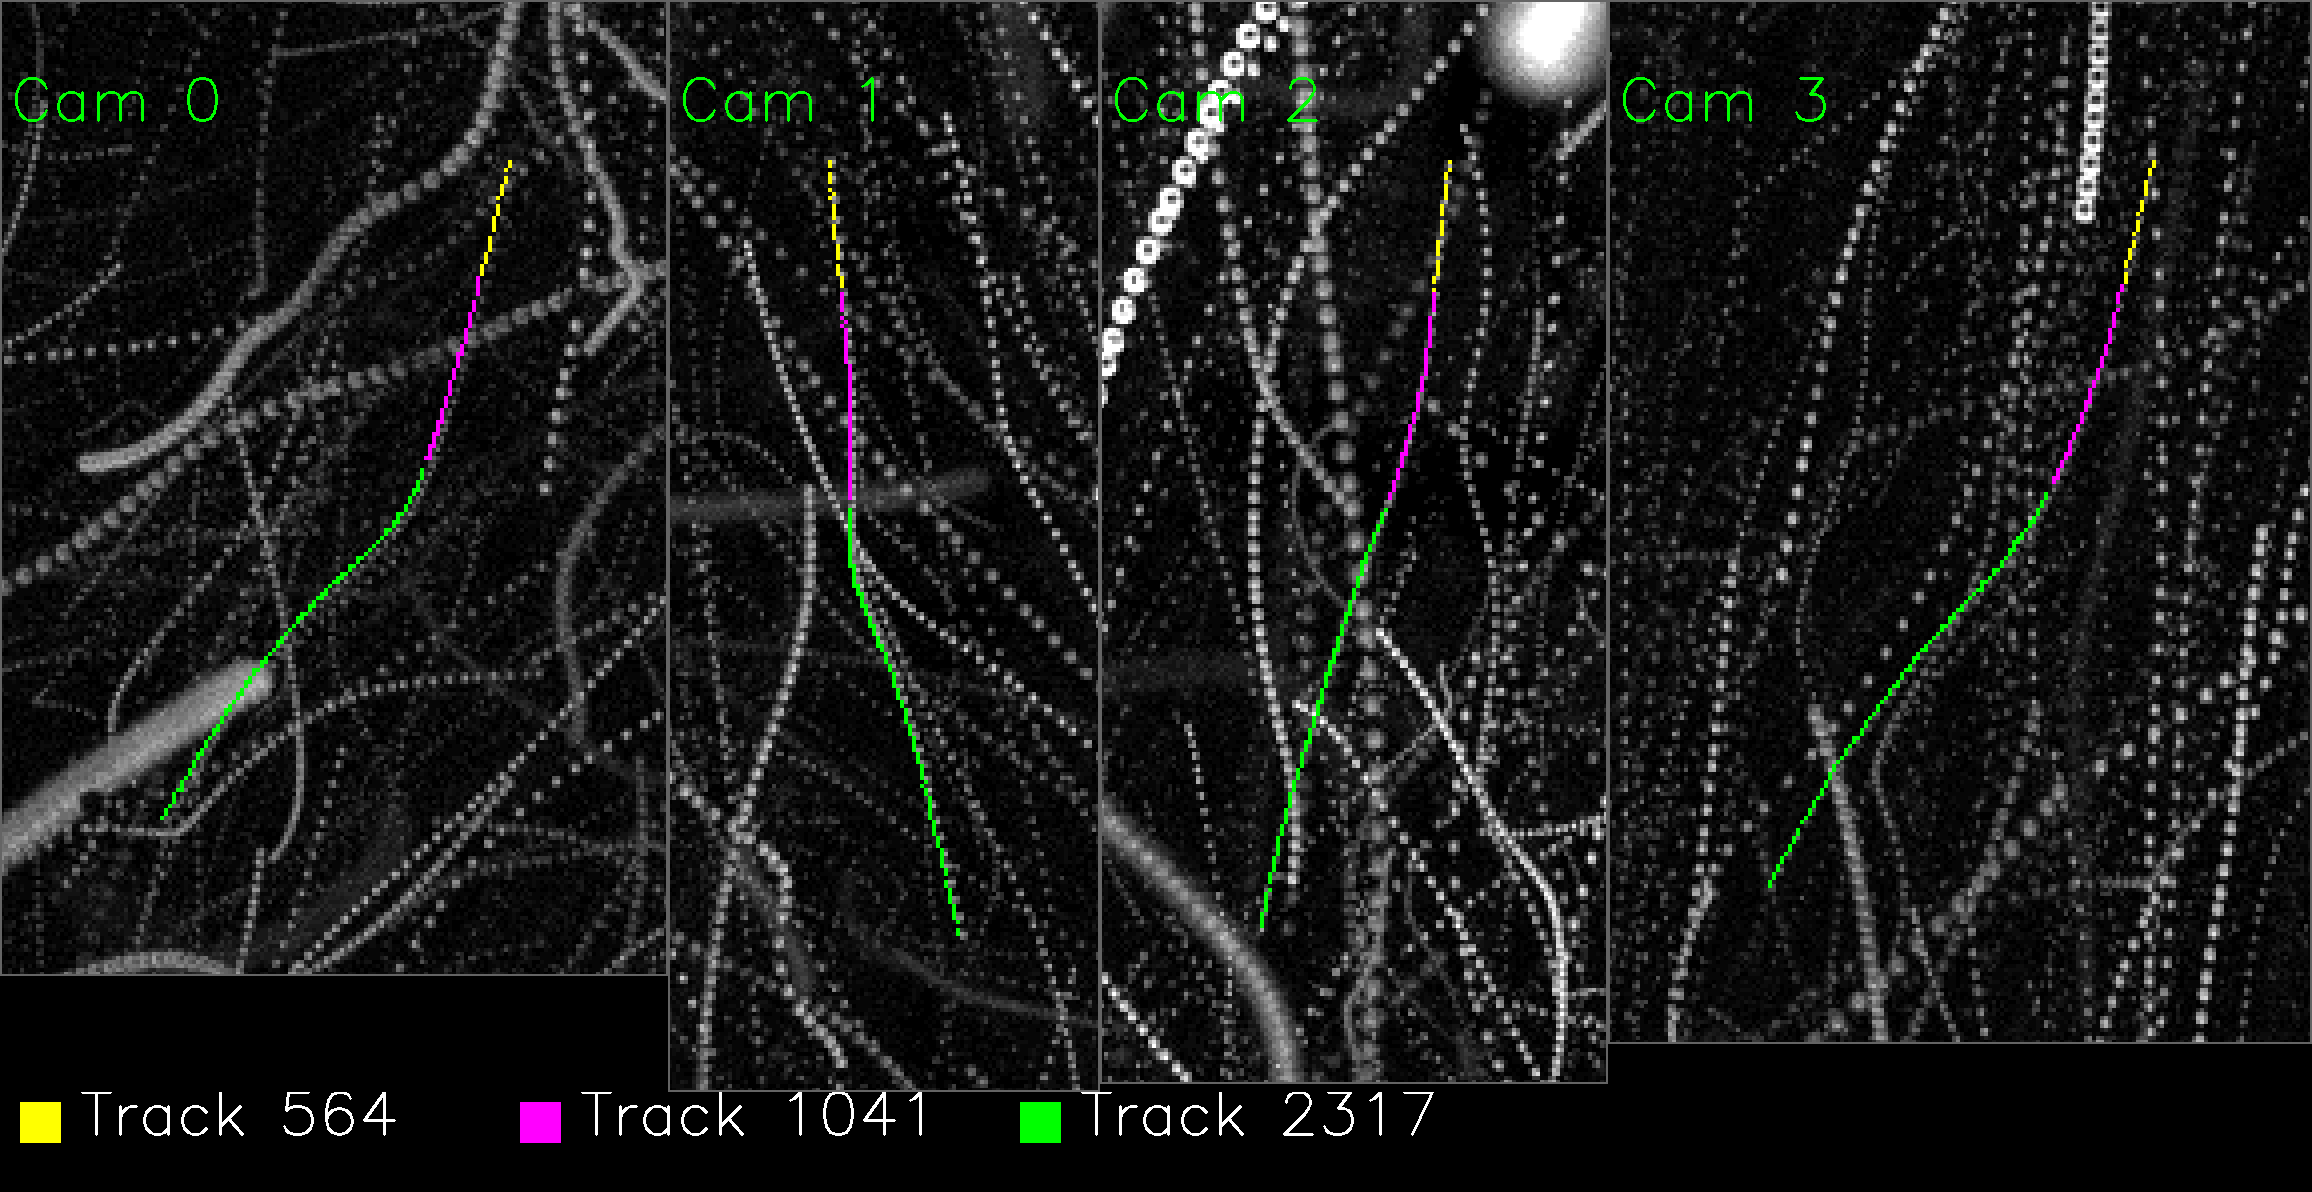

In [2]:

import cv2
import numpy as np
import os
from IPython.display import display, Image

# --- Configuration ---
track_select = [564, 1041, 2317]
padding = 40
cameras = [0, 1, 2, 3]
scale_factor = 4  # Upscale for visibility WITHOUT smoothing
colors = {
    564: (0, 255, 255),   # Yellow
    1041: (255, 0, 255),  # Magenta
    2317: (0, 255, 0)     # Green
}
default_color = (255, 255, 255)

print(f"Generating HI-RES visualization for tracks: {track_select}")

# --- Helper: Re-acquire image lists ---
def get_image_lists(proj_dir):
    cfg_path = os.path.join(proj_dir, 'config.txt')
    img_lists = {}
    if os.path.exists(cfg_path):
        with open(cfg_path, 'r') as f:
            lines = f.readlines()
            for i, line in enumerate(lines):
                if '# Image File Path' in line:
                    for j in range(1, 5): 
                        if i+j < len(lines):
                            txt_path = lines[i+j].strip()
                            if txt_path and os.path.exists(txt_path):
                                with open(txt_path, 'r') as tf:
                                    img_lists[j-1] = [l.strip() for l in tf.readlines()]
    return img_lists

if 'project_root' not in locals():
    project_root = r'I:/VONSET/Data/20230125/T1/Processed'
    print(f"Warning: project_root not found, using default: {project_root}")

all_img_lists = get_image_lists(project_root)

# --- Main Logic ---
if 'tracks' not in locals():
    print("Error: 'tracks' dictionary not found. Run Cell 1.")
else:
    # 1. Output Track Ranges
    valid_tracks = []
    print("-" * 30)
    for tid in track_select:
        if tid in tracks:
            frames = [r[0] for r in tracks[tid]]
            if frames:
                print(f"Track {tid}: Frames {min(frames)} - {max(frames)}")
                valid_tracks.append(tid)
            else:
                print(f"Track {tid}: No frames found.")
        else:
            print(f"Track {tid}: Not found in data.")
    print("-" * 30)

    # 2. Compute Global Bounds
    global_min_x = {c: float('inf') for c in cameras}
    global_max_x = {c: float('-inf') for c in cameras}
    global_min_y = {c: float('inf') for c in cameras}
    global_max_y = {c: float('-inf') for c in cameras}
    
    all_frames_global = []
    
    for tid in valid_tracks:
        for r in tracks[tid]:
            all_frames_global.append(r[0])
            cam_data = r[4]
            for cam_idx in cameras:
                if cam_idx in cam_data:
                    x, y = cam_data[cam_idx][:2]
                    global_min_x[cam_idx] = min(global_min_x[cam_idx], x)
                    global_max_x[cam_idx] = max(global_max_x[cam_idx], x)
                    global_min_y[cam_idx] = min(global_min_y[cam_idx], y)
                    global_max_y[cam_idx] = max(global_max_y[cam_idx], y)
    
    if valid_tracks:
        f_start_g = min(all_frames_global)
        f_end_g = max(all_frames_global)
        
        row_images = []
        
        for cam_idx in cameras:
            if global_min_x[cam_idx] == float('inf'):
                # Empty placeholder
                h, w = 300 * scale_factor, 300 * scale_factor
                img_crop = np.zeros((h, w, 3), dtype=np.uint8)
                cv2.putText(img_crop, f"Cam {cam_idx}: No Data", (50, 150*scale_factor), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2)
                row_images.append(img_crop)
                continue
                
            # Load images
            target_frames = list(range(f_start_g, f_end_g + 1))
            if len(target_frames) > 60:
                target_frames = np.linspace(f_start_g, f_end_g, 60, dtype=int).tolist()
                
            accum_img = None
            if cam_idx in all_img_lists:
                cam_files = all_img_lists[cam_idx]
                for fid in target_frames:
                    idx = int(fid)
                    if 0 <= idx < len(cam_files):
                        fpath = cam_files[idx]
                        if os.path.exists(fpath):
                            frame = cv2.imread(fpath)
                            if frame is not None:
                                if accum_img is None:
                                    accum_img = frame.astype(np.float32)
                                else:
                                    accum_img = np.maximum(accum_img, frame.astype(np.float32))
            
            if accum_img is None:
                accum_img = np.zeros((1024, 1280, 3), dtype=np.uint8)
            else:
                accum_img = accum_img.astype(np.uint8)
                
            # Crop
            H, W = accum_img.shape[:2]
            x0 = max(0, int(global_min_x[cam_idx] - padding))
            y0 = max(0, int(global_min_y[cam_idx] - padding))
            x1 = min(W, int(global_max_x[cam_idx] + padding))
            y1 = min(H, int(global_max_y[cam_idx] + padding))

            if x1 <= x0 or y1 <= y0:
                crop = np.zeros((100, 100, 3), dtype=np.uint8)
            else:
                crop = accum_img[y0:y1, x0:x1].copy()
                
            # Draw Points (1 pixel size)
            for tid in valid_tracks:
                color = colors.get(tid, default_color)
                for r in tracks[tid]:
                    if cam_idx in r[4]:
                        px, py = r[4][cam_idx][:2]
                        cx, cy = int(px - x0), int(py - y0)
                        if 0 <= cx < crop.shape[1] and 0 <= cy < crop.shape[0]:
                            # Direct pixel access for 1px size
                            crop[cy, cx] = color 
                            
            # Upscale Nearest Neighbor
            # This makes 1px points become scale_factor*scale_factor blocks
            crop_res = cv2.resize(crop, (0,0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
            
            # Label
            cv2.putText(crop_res, f"Cam {cam_idx}", (10, 30*scale_factor), cv2.FONT_HERSHEY_SIMPLEX, 0.5*scale_factor, (0, 255, 0), 2)
            cv2.rectangle(crop_res, (0,0), (crop_res.shape[1]-1, crop_res.shape[0]-1), (100,100,100), 2)
            
            row_images.append(crop_res)
            
        # Display Row
        if row_images:
            max_h = max(img.shape[0] for img in row_images)
            final_cols = []
            for img in row_images:
                h = img.shape[0]
                if h < max_h:
                    img = cv2.copyMakeBorder(img, 0, max_h - h, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
                final_cols.append(img)
            
            montage = np.hstack(final_cols)
            
            # Legend
            legend_h = 50 * scale_factor // 2
            legend = np.zeros((legend_h, montage.shape[1], 3), dtype=np.uint8)
            x_off = 20
            
            for tid in valid_tracks:
                color = colors.get(tid, default_color)
                # Draw a representative block
                cv2.rectangle(legend, (x_off, 10), (x_off+10*scale_factor, 10+10*scale_factor), color, -1)
                text = f"Track {tid}"
                cv2.putText(legend, text, (x_off + 15*scale_factor, 10+8*scale_factor), cv2.FONT_HERSHEY_SIMPLEX, 0.5*scale_factor, (255,255,255), 2)
                x_off += 250 * scale_factor // 2
                
            final_vis = np.vstack([montage, legend])
            
            display(Image(data=cv2.imencode('.png', final_vis)[1]))


In [3]:
import pyopenlpt as lpt
redirector = lpt.PythonStreamRedirector()

basic_settings = lpt.BasicSetting()
basic_settings.readConfig(r"I:\VONSET\Data\20230125\T1\Processed/config.txt")

imgio_list = []
for path in basic_settings._image_file_paths:
    io = lpt.ImageIO()
    io.loadImgPath("", path)
    imgio_list.append(io)

num_cams = len(imgio_list)

# load tracks
basic_settings._load_track_path = r'I:\VONSET\Data\20230125\T1\Processed/Results/ConvergeTrack/'
basic_settings._load_track_frame = 25
stb = lpt.STB(basic_settings, basic_settings._object_types[0], basic_settings._object_config_paths[0])
stb.loadTracksAll(basic_settings._load_track_path, basic_settings._load_track_frame)

print(len(stb._long_track_active))

curr_frame = stb._long_track_active[0]._t_list[-1]

num_cams = len(imgio_list)
frame_id = curr_frame + 1

image_list = []
for i in range(num_cams):
    image_list.append(imgio_list[i].loadImg(frame_id))

objs_pred = []
for tr in stb._long_track_active:
    objs_pred.append(stb.predictNext(tr))

print(f"Predicted {len(objs_pred)} objects for frame {frame_id}.")

Estimating OTF...
Camera 0 (a,b,c,alpha) = 178.716,1.38555,1.3256,0

Camera 1 (a,b,c,alpha) = 203.923,1.27958,1.24036,0

Camera 2 (a,b,c,alpha) = 226.289,1.22811,1.16587,0

Camera 3 (a,b,c,alpha) = 193.924,1.41574,1.32785,0

348
Predicted 348 objects for frame 26.


In [ ]:
# 2. Find Index of Track 564
target_id = 564

if 'tracks' in locals() and target_id in tracks:
    # Get ground truth point from loaded CSV dictionary
    track_564 = tracks[target_id]
    pt_564 = track_564[-1] # tuple: (frame, x, y, z, ...)
    
    gt_frame = pt_564[0]
    gt_pos = np.array([pt_564[1], pt_564[2], pt_564[3]])
    
    print(f"\nSearching for Track {target_id}...")
    print(f"  GT Last Point: Frame {gt_frame}, Pos ({gt_pos[0]:.4f}, {gt_pos[1]:.4f}, {gt_pos[2]:.4f})")
    
    found_indices = []
    
    for i, tr in enumerate(stb._long_track_active):
        if len(tr._obj3d_list) > 0:
            last_obj = tr._obj3d_list[-1]
            stb_pos = np.array([last_obj._pt_center[0], last_obj._pt_center[1], last_obj._pt_center[2]])
            
            # Distance check
            dist = np.linalg.norm(gt_pos - stb_pos)
            
            if dist < 0.001: # 1 micron tolerance
                print(f"  [MATCH] Found at index {i}!")
                print(f"          STB Last Point: Frame {tr._t_list[-1]}, Pos ({stb_pos[0]:.4f}, {stb_pos[1]:.4f}, {stb_pos[2]:.4f})")
                found_indices.append(i)



Searching for Track 564...
  GT Last Point: Frame 25, Pos (-18.3712, -8.9688, -22.3805)
  [MATCH] Found at index 118!
          STB Last Point: Frame 25, Pos (-18.3712, -8.9688, -22.3805)


Generating Prediction Visualization for Track Index 118
Using existing prediction for index 118


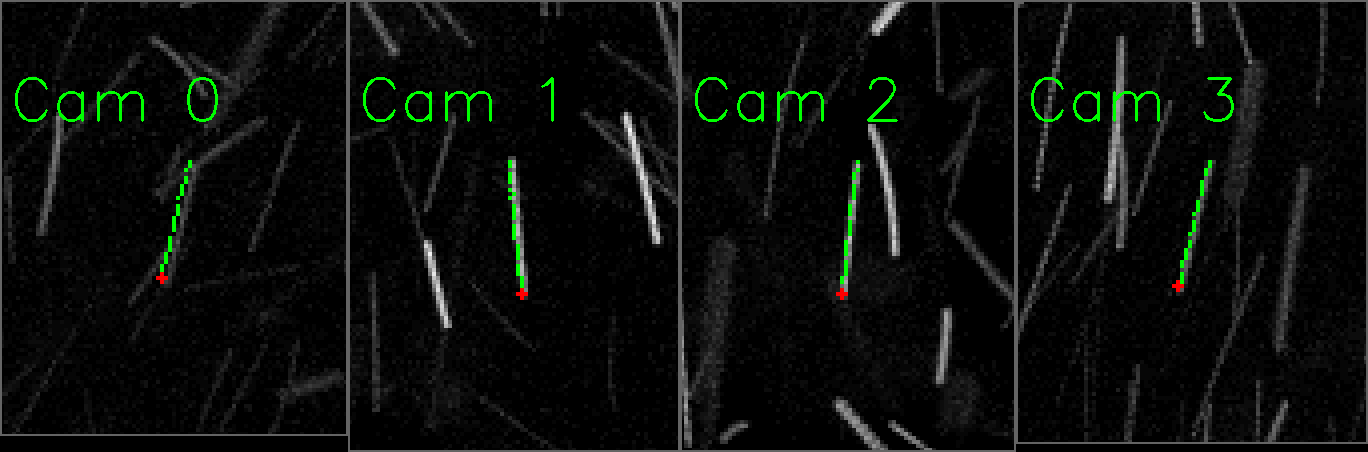

In [12]:

import cv2
import numpy as np
import os
from IPython.display import display, Image

# --- Configuration ---
target_idx = 118
vis_frames = range(0, 27) # 0 to 26 inclusive
scale_factor = 4
padding = 40
cameras = [0, 1, 2, 3]

# Colors (BGR)
col_history = (0, 255, 0) # Green
col_pred = (0, 0, 255)    # Red

print(f"Generating Prediction Visualization for Track Index {target_idx}")

# --- Helper: Re-acquire image lists ---
def get_image_lists(proj_dir):
    cfg_path = os.path.join(proj_dir, 'config.txt')
    img_lists = {}
    if os.path.exists(cfg_path):
        with open(cfg_path, 'r') as f:
            lines = f.readlines()
            for i, line in enumerate(lines):
                if '# Image File Path' in line:
                    for j in range(1, 5): 
                        if i+j < len(lines):
                            txt_path = lines[i+j].strip()
                            if txt_path and os.path.exists(txt_path):
                                with open(txt_path, 'r') as tf:
                                    img_lists[j-1] = [l.strip() for l in tf.readlines()]
    return img_lists

if 'project_root' not in locals():
    project_root = r'I:/VONSET/Data/20230125/T1/Processed'
    print(f"Warning: project_root not found, using default: {project_root}")

all_img_lists = get_image_lists(project_root)

# --- Main Logic ---
if 'stb' not in locals():
    print("Error: 'stb' object not found. Please run previous cells.")
elif target_idx >= len(stb._long_track_active):
    print(f"Error: Index {target_idx} out of range (Max: {len(stb._long_track_active)-1})")
else:
    track = stb._long_track_active[target_idx]
    
    # 1. Get/Calculate Prediction
    pred_obj = None
    if 'objs_pred' in locals() and target_idx < len(objs_pred):
        pred_obj = objs_pred[target_idx]
        if pred_obj: # Ensure it's not None
             print(f"Using existing prediction for index {target_idx}")
    
    if pred_obj is None:
        print(f"Calculating prediction for index {target_idx}...")
        pred_obj = stb.predictNext(track)
    
    if pred_obj:
        # Ensure 2D (re-project to be safe)
        if 'basic_settings' in locals():
            pred_obj.projectObject2D(basic_settings._cam_list)
        else:
            print("Warning: basic_settings not found, cannot project prediction 2D.")
            
    # 2. Compute Global Bounds
    global_min_x = {c: float('inf') for c in cameras}
    global_max_x = {c: float('-inf') for c in cameras}
    global_min_y = {c: float('inf') for c in cameras}
    global_max_y = {c: float('-inf') for c in cameras}
    
    # helper to update bounds
    def update_bounds(c_idx, x, y):
        global_min_x[c_idx] = min(global_min_x[c_idx], x)
        global_max_x[c_idx] = max(global_max_x[c_idx], x)
        global_min_y[c_idx] = min(global_min_y[c_idx], y)
        global_max_y[c_idx] = max(global_max_y[c_idx], y)

    # History Points
    for obj in track._obj3d_list:
        # Check obj._obj2d_list - in pybind it is a list of Object2D
        # We need to manually match camera index to list index?
        # Usually list index == camera index if configured that way.
        # But safest is to iterate
        obj2d_list = obj._obj2d_list
        for c_idx in cameras:
            if c_idx < len(obj2d_list):
                 pt = obj2d_list[c_idx]._pt_center
                 # assuming pt is indexable (x,y)
                 update_bounds(c_idx, pt[0], pt[1])
                 
    # Prediction Point
    if pred_obj:
        obj2d_list = pred_obj._obj2d_list
        for c_idx in cameras:
            if c_idx < len(obj2d_list):
                 pt = obj2d_list[c_idx]._pt_center
                 update_bounds(c_idx, pt[0], pt[1])

    row_images = []
    
    for cam_idx in cameras:
        if global_min_x[cam_idx] == float('inf'):
            # Placeholder
            h, w = 300 * scale_factor, 300 * scale_factor
            img_crop = np.zeros((h, w, 3), dtype=np.uint8)
            cv2.putText(img_crop, f"Cam {cam_idx}: No Data", (50, 150*scale_factor), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2)
            row_images.append(img_crop)
            continue
            
        # 3. Load Images (Overlay 0-26)
        accum_img = None
        if cam_idx in all_img_lists:
            cam_files = all_img_lists[cam_idx]
            for fid in vis_frames:
                if 0 <= fid < len(cam_files):
                    fpath = cam_files[fid]
                    if os.path.exists(fpath):
                        frame = cv2.imread(fpath)
                        if frame is not None:
                            if accum_img is None:
                                accum_img = frame.astype(np.float32)
                            else:
                                accum_img = np.maximum(accum_img, frame.astype(np.float32))
        
        if accum_img is None:
             accum_img = np.zeros((1024, 1280, 3), dtype=np.uint8)
        else:
             accum_img = accum_img.astype(np.uint8)
             
        # 4. Crop
        H, W = accum_img.shape[:2]
        x0 = max(0, int(global_min_x[cam_idx] - padding))
        y0 = max(0, int(global_min_y[cam_idx] - padding))
        x1 = min(W, int(global_max_x[cam_idx] + padding))
        y1 = min(H, int(global_max_y[cam_idx] + padding))

        if x1 <= x0 or y1 <= y0:
            crop = np.zeros((100, 100, 3), dtype=np.uint8)
        else:
            crop = accum_img[y0:y1, x0:x1].copy()
            
        # 5. Draw
        # Draw History
        for obj in track._obj3d_list:
            if cam_idx < len(obj._obj2d_list):
                px, py = obj._obj2d_list[cam_idx]._pt_center[0], obj._obj2d_list[cam_idx]._pt_center[1]
                cx, cy = int(px - x0), int(py - y0)
                if 0 <= cx < crop.shape[1] and 0 <= cy < crop.shape[0]:
                    crop[cy, cx] = col_history
                    
        # Draw Prediction
        pred_obj.projectObject2D(basic_settings._cam_list)
        if pred_obj and cam_idx < len(pred_obj._obj2d_list):
            px, py = pred_obj._obj2d_list[cam_idx]._pt_center[0], pred_obj._obj2d_list[cam_idx]._pt_center[1]
            cx, cy = int(px - x0), int(py - y0)
            if 0 <= cx < crop.shape[1] and 0 <= cy < crop.shape[0]:
                # Draw a small cross for prediction (manually on pixels)
                # Center
                crop[cy, cx] = col_pred
                # Plus shape
                if cy > 0: crop[cy-1, cx] = col_pred
                if cy < crop.shape[0]-1: crop[cy+1, cx] = col_pred
                if cx > 0: crop[cy, cx-1] = col_pred
                if cx < crop.shape[1]-1: crop[cy, cx+1] = col_pred
        
        # Upscale
        crop_res = cv2.resize(crop, (0,0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
        
        # Label
        cv2.putText(crop_res, f"Cam {cam_idx}", (10, 30*scale_factor), cv2.FONT_HERSHEY_SIMPLEX, 0.5*scale_factor, (0, 255, 0), 2)
        cv2.rectangle(crop_res, (0,0), (crop_res.shape[1]-1, crop_res.shape[0]-1), (100,100,100), 2)
        
        row_images.append(crop_res)
        
    # Display Row
    if row_images:
        max_h = max(img.shape[0] for img in row_images)
        final_cols = []
        for img in row_images:
            h = img.shape[0]
            if h < max_h:
                img = cv2.copyMakeBorder(img, 0, max_h - h, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            final_cols.append(img)
        
        montage = np.hstack(final_cols)
        
        final_vis = np.vstack([montage])
        display(Image(data=cv2.imencode('.png', final_vis)[1]))
